In [1]:
import numpy as np
import sklearn
print("NumPy version:", np.__version__)
print("scikit-learn version:", sklearn.__version__)
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

NumPy version: 2.2.4
scikit-learn version: 1.6.1


In [2]:
# Load data
df = pd.read_csv(r"C:\Users\HP\Documents\BSc in Data Science\Year 2\Semester 4\Data Mining & Machine Learning\ml_model_dataset.csv")

In [3]:
# Select and scale LIWC features
features = [
    'i_words_count', 'positive_tone_count', 'negative_tone_count',
    'social_words_count', 'cognitive_proc_count', 'allure_count', 'moralization_count'
]
X = df[features]
X_scaled = StandardScaler().fit_transform(X)

In [4]:
# Drop duplicates
df = df.drop_duplicates()
print(f"Duplicates removed. New shape: {df.shape}")

Duplicates removed. New shape: (15610, 15)


In [5]:
# dropping rows with any missing values
df = df.dropna()
print(f"Dropped rows with missing values. New shape: {df.shape}")

Dropped rows with missing values. New shape: (10896, 15)


In [6]:
# Select LIWC-like features (columns I to O) and the target
features = [
    'i_words_count', 'positive_tone_count', 'negative_tone_count',
    'social_words_count', 'cognitive_proc_count', 'allure_count',
    'moralization_count'
]
target = 'rating_class'

X = df[features].copy()
y = df[target].copy()

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [8]:
from sklearn.preprocessing import LabelEncoder

# Encode the target column
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['rating_class'])


In [9]:
# 1. Create training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [10]:
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 1. Show original class distribution
original_class_counts = Counter(y)
print("Original Class Distribution:")
for label, count in original_class_counts.items():
    class_name = label_encoder.inverse_transform([label])[0]
    print(f"  {class_name}: {count}")

# 2. Balance the data using SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_scaled, y)

# 3. Show balanced class distribution
balanced_class_counts = Counter(y_smote)
print("\nBalanced Class Distribution (after SMOTE):")
for label, count in balanced_class_counts.items():
    class_name = label_encoder.inverse_transform([label])[0]
    print(f"  {class_name}: {count}")

# 4. Train-test split (80% train, 20% test)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)

# Print the shape of the splits
print(f"\nTraining set shape: X={X_train_bal.shape}, y={y_train_bal.shape}")
print(f"Testing set shape:  X={X_test_bal.shape}, y={y_test_bal.shape}")


Original Class Distribution:
  high: 8256
  medium: 850
  low: 1790

Balanced Class Distribution (after SMOTE):
  high: 8256
  medium: 8256
  low: 8256

Training set shape: X=(19814, 7), y=(19814,)
Testing set shape:  X=(4954, 7), y=(4954,)


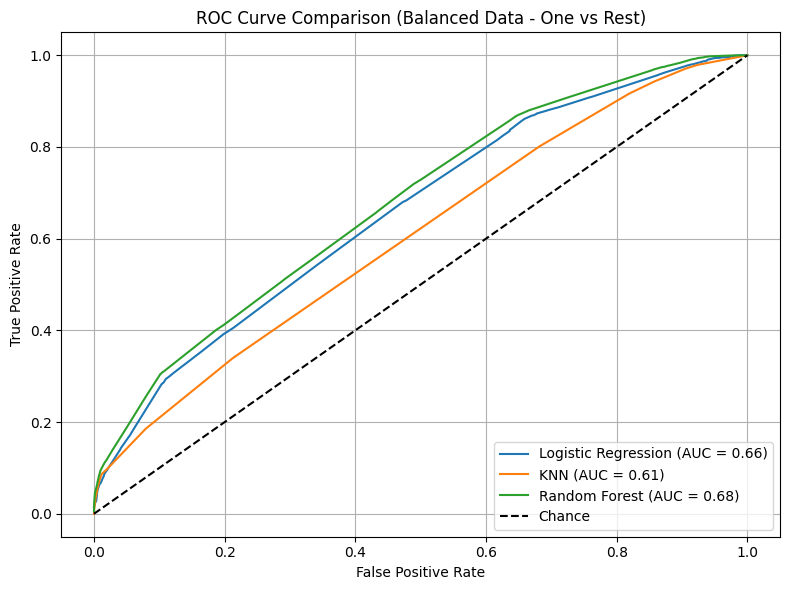

In [11]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# 1. Binarize labels for ROC curve (multi-class handling)
classes = np.unique(y_train_bal)
y_train_bin = label_binarize(y_train_bal, classes=classes)
y_test_bin = label_binarize(y_test_bal, classes=classes)
n_classes = y_train_bin.shape[1]

# 2. Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# 3. Plot ROC curves for each model
plt.figure(figsize=(8, 6))

for name, model in models.items():
    clf = OneVsRestClassifier(model)
    clf.fit(X_train_bal, y_train_bin)
    y_score = clf.predict_proba(X_test_bal)

    # Compute ROC curve and AUC for each class
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    auc_macro = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, label=f'{name} (AUC = {auc_macro:.2f})')

# 4. Plot baseline
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

# 5. Final touches
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Balanced Data - One vs Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



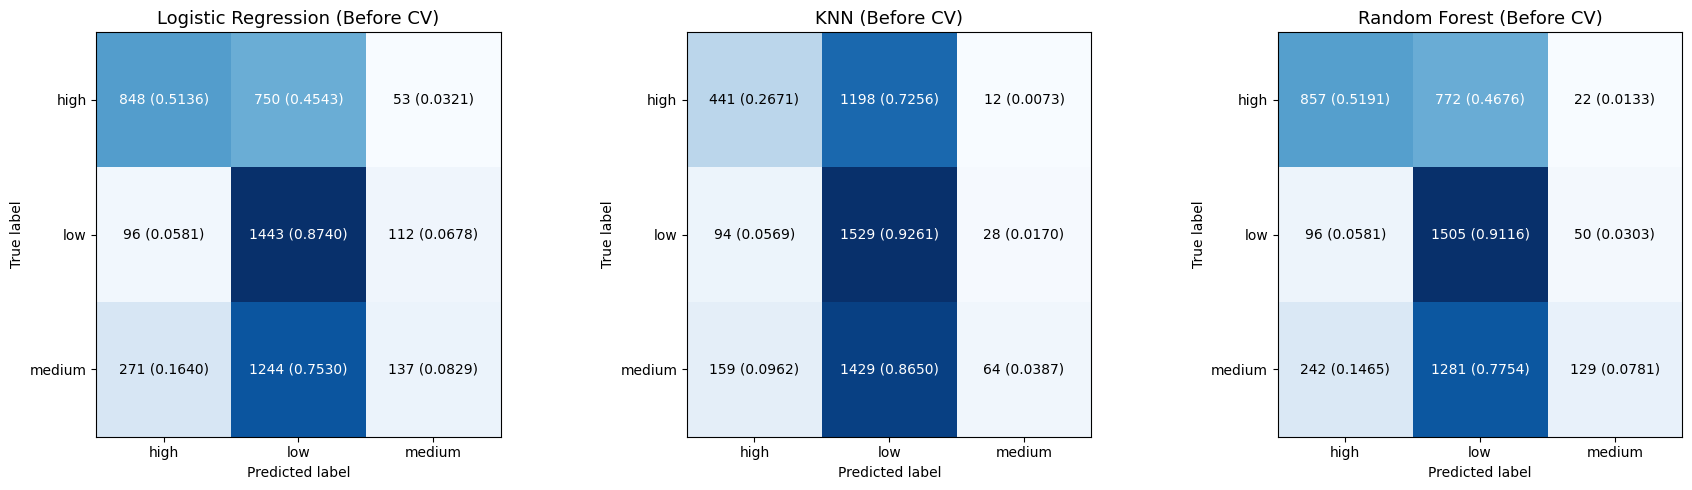

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Define your models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, model) in zip(axes, models.items()):
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test_bal)

    cm = confusion_matrix(y_test_bal, y_pred)
    cm_norm = confusion_matrix(y_test_bal, y_pred, normalize='true')

    # Plot the heatmap manually
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.set_title(f'{name} (Before CV)', fontsize=13)
    tick_marks = np.arange(len(label_encoder.classes_))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(label_encoder.classes_)
    ax.set_yticklabels(label_encoder.classes_)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    # Add raw + normalized numbers
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > thresh else "black"
            ax.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]:.4f})",
                    ha='center', va='center', color=color, fontsize=10)

plt.tight_layout()
plt.show()


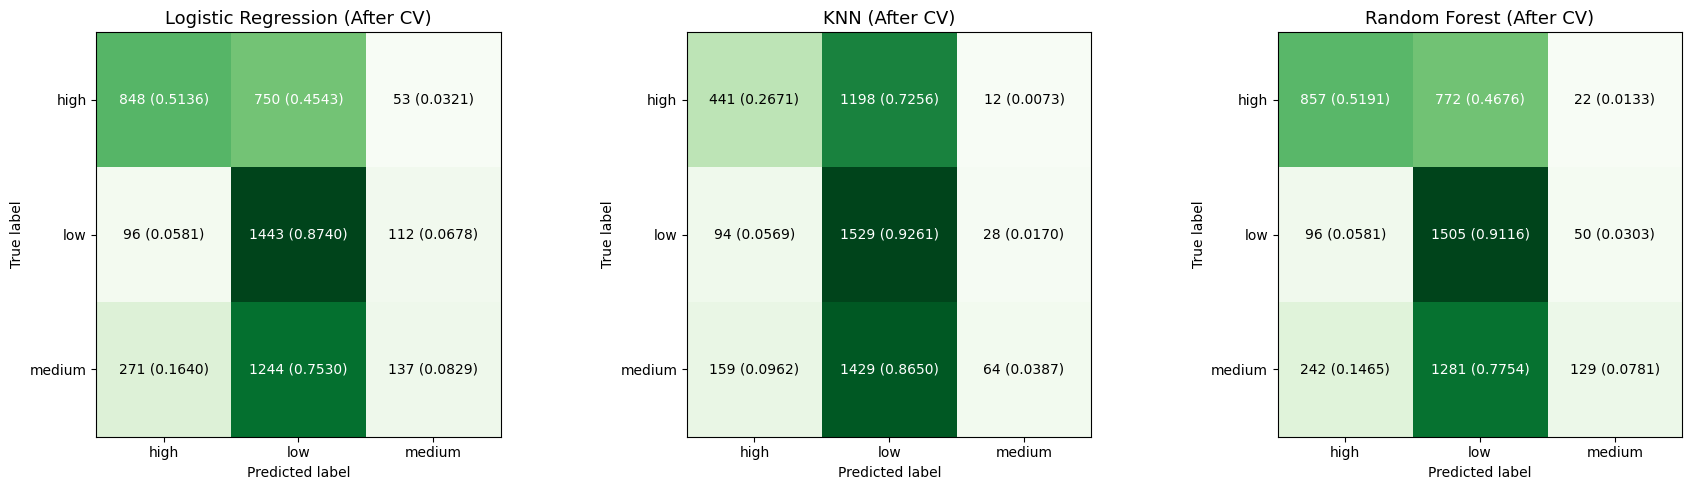

In [19]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# ========== AFTER CROSS-VALIDATION ==========
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, model) in zip(axes, models.items()):
    # Cross-validated predictions on training data
    y_cv_pred = cross_val_predict(model, X_train_bal, y_train_bal, cv=5)

    # Refit and evaluate on test set
    model.fit(X_train_bal, y_train_bal)
    y_test_pred = model.predict(X_test_bal)

    cm = confusion_matrix(y_test_bal, y_test_pred)
    cm_norm = confusion_matrix(y_test_bal, y_test_pred, normalize='true')

    # Plot manually for custom styling
    im = ax.imshow(cm, interpolation='nearest', cmap='Greens')
    ax.set_title(f'{name} (After CV)', fontsize=13)
    tick_marks = np.arange(len(label_encoder.classes_))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(label_encoder.classes_)
    ax.set_yticklabels(label_encoder.classes_)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    # Add values: count + normalized
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > thresh else "black"
            ax.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]:.4f})",
                    ha='center', va='center', color=color, fontsize=10)

plt.tight_layout()
plt.show()
